In [1]:
%load_ext rpy2.ipython
%load_ext retina

In [3]:
%%R
library (ape)
library(vegan)

### 1. PACo FUNCTION: adjustemt prior to Procrustes analysis
PACo <- function (H.dist, P.dist, HP.bin)
{ 
    HP.bin <- which(HP.bin > 0, arr.in=TRUE)
    H.PCo <- pcoa(H.dist, correction="cailliez")$vectors #Performs PCo of Host distances 
    P.PCo <- pcoa(P.dist, correction="cailliez")$vectors #Performs PCo of Parasite distances
    H.PCo <- H.PCo[HP.bin[,1],] #adjust Host PCo vectors 
    P.PCo <- P.PCo[HP.bin[,2],]  ##adjust Parasite PCo vectors
    list (H.PCo = H.PCo, P.PCo = P.PCo)
}

In [43]:
%%R
### 2. DATA INPUT
#TreeH <- read.tree("../../Downloads/example/gophers/phylo_gopher.tre")
#TreeP <- read.tree("../../Downloads/example/gophers/phylo_lice.tre")
TreeH <- read.tree("rabosky_trimmed.tre")
TreeP <- read.tree("RAxML_bestTree.fishpoo_ssu.raxml")

#Compute patristic distances:
host.D <- cophenetic (TreeH)
para.D <- cophenetic (TreeP)

## Read HP: host-parasite association matrix
##          Hosts in rows, parasites in columns. Taxa names are included in 
##          the file and should match those in tree, sequence or distance files. 
HP <- as.matrix(read.table("fish-bacteria_links.tsv", header=TRUE)) 

#Sort host and parasite taxa in distance matrices to match the HP matrix:
host.D <- host.D[rownames(HP),rownames(HP)]
para.D <- para.D[colnames(HP), colnames(HP)]

In [44]:
%%R

### 3. APPLY PACo FUNCTION  
PACo.fit <- PACo(host.D, para.D, HP)
HP.proc <- procrustes(PACo.fit$H.PCo, PACo.fit$P.PCo) #Procrustes Ordination 
NLinks = sum(HP) #Number of H-P links; needed for further computations

integer(0)


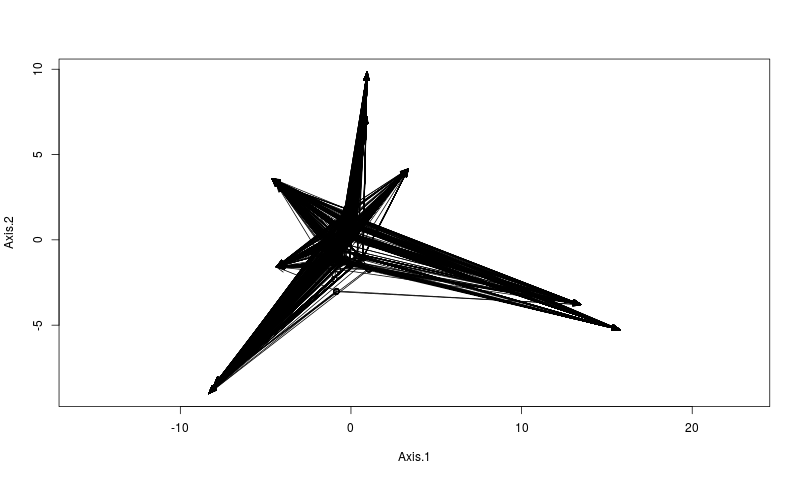

In [45]:
%%R -w 800 -h 480 -u px

#3.1 Plot of host and parasite ordination:
HostX <- HP.proc$X #host ordination matrix
ParY <- HP.proc$Yrot #parasite ordination matrix, scaled and rotated to fit HostX

#Plotting host and parasite ordinations
plot(HostX, asp=1, pch=46) 
points(ParY, pch=1)
arrows(ParY[,1], ParY[,2], HostX[,1], HostX[,2], length=0.12, angle=15, xpd=FALSE)
HostX <- unique(HP.proc$X) 
ParY <- unique(HP.proc$Yrot) #unique() removes duplicated points - convenient for labelling of points below
identify(ParY[,1], ParY[,2], rownames(ParY), offset=0.3, xpd=FALSE, cex=0.8) #interactive labelling
identify(HostX[,1], HostX[,2], rownames(HostX),offset=0.3, xpd=TRUE, cex= 0.8)

In [ ]:
%%R
# 3.2 Goodness-of-fit-test
m2.obs <- HP.proc$ss #observed sum of squares
N.perm = 100000 #set number of permutations for testing
P.value = 0
seed <-.Random.seed[trunc(runif(1,1,626))]
set.seed(seed)

#set.seed(5) ### use this option to obtain reproducible randomizations
for (n in c(1:N.perm)) { 
    #control statement to avoid all parasites beig associated to a single host
    if (NLinks <= nrow(HP) | NLinks <= ncol(HP)) { 
        flag2 <- TRUE 
        while (flag2 == TRUE) { 
            HP.perm <- t(apply(HP,1,sample))
            if(any(colSums(HP.perm) == NLinks)) flag2 <- TRUE else flag2 <- FALSE
        }
    } else { HP.perm <- t(apply(HP,1,sample)) } #permutes each HP row independently
    PACo.perm <- PACo(host.D, para.D, HP.perm)
    m2.perm <- procrustes(PACo.perm$H.PCo, PACo.perm$P.PCo)$ss #randomized sum of squares
    #write (m2.perm, file = "D:/m2_perm.txt", sep ="\t", append =TRUE) 
    #option to save m2 from each permutation
    if (m2.perm <= m2.obs) {P.value = P.value + 1} 
}
P.value <- P.value/N.perm
cat(" The observed m2 is ", m2.obs, "\n", "P-value = ", P.value, " based on ", N.perm," permutations.")

In [ ]:
%%R
#3.3 Contribution of individual links

HP.ones <- which(HP > 0, arr.in=TRUE)
SQres.jackn <- matrix(rep(NA, NLinks**2), NLinks)# empty matrix of jackknifed squared residuals

#colnames identify the H-P link
colnames (SQres.jackn) <- paste(rownames(HP.proc$X),rownames(HP.proc$Yrot), sep="-") 
t.critical = qt(0.975,NLinks-1) #Needed to compute 95% confidence intervals.

#PACo setting the ith link = 0
for(i in c(1:NLinks)) {
    HP.ind <- HP
    HP.ind[HP.ones[i,1],HP.ones[i,2]]=0
    PACo.ind <- PACo(host.D, para.D, HP.ind)
    Proc.ind <- procrustes(PACo.ind$H.PCo, PACo.ind$P.PCo) 
    res.Proc.ind <- c(residuals(Proc.ind))
    res.Proc.ind <- append (res.Proc.ind, NA, after= i-1)
    SQres.jackn [i, ] <- res.Proc.ind #Append residuals to matrix of jackknifed squared residuals
}

In [ ]:
%%R
#Jackknifed residuals are squared
SQres.jackn <- SQres.jackn**2

# Vector of original square residuals
SQres <- (residuals (HP.proc))**2 

#jackknife calculations:
SQres.jackn <- SQres.jackn*(-(NLinks-1))
SQres <- SQres*NLinks
SQres.jackn <- t(apply(SQres.jackn, 1, "+", SQres)) #apply jackknife function to matrix
phi.mean <- apply(SQres.jackn, 2, mean, na.rm = TRUE) #mean jackknife estimate per link
phi.UCI <- apply(SQres.jackn, 2, sd, na.rm = TRUE) #standard deviation of estimates
phi.UCI <- phi.mean + t.critical * phi.UCI/sqrt(NLinks) #upper 95% confidence interval

In [ ]:
%%R -w 800 -h 480 -u px

#barplot of squared jackknifed residuals
pat.bar <- barplot(phi.mean, names.arg = " ", space = 0.25, col="white", xlab= "Host-parasite links", ylab= "Squared residuals", ylim=c(0, max(phi.UCI)), cex.lab=1.2)
text(pat.bar, par("usr")[3] - 0.001, srt = 330, adj = 0, labels = colnames(SQres.jackn), xpd = TRUE, font = 1, cex=0.6)
arrows(pat.bar, phi.mean, pat.bar, phi.UCI, length= 0.05, angle=90)
abline(a=median(phi.mean), b=0, lty=2, xpd=FALSE) #draws a line across the median residual value